# Main

## Mount Google Drive, Link to folder & install requirements

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6756"
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Install requirements
!pip install -qr /content/assignment/requirements.txt

## Imports

In [3]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# My modules
from models import GAN, Autoencoder
from run_exp import train_autoencoder, train_gan
from utils import to_device, train_val_test_split, generate_samples

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

torch.manual_seed(42)

## Arguments

In [4]:
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  embedding_dim: int = 64
  random_dim: int = 100
  hidden_D: Tuple[int, ...] = (128, 64, 32)
  hidden_G: Tuple[int, ...] = (128, 256)

  # Optimization
  n_critic: int = 5
  clip_value: float = 0.01
  lr: float = 0.00005
  epochs: int = 200

  # Miscellaneous
  device: str = 'cpu'
  decoder = torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")
  verbose: bool = True


@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  latent_dim: int = 64
  hidden: Tuple[int, ...] = (9,16,32)

  # Optimization
  lr: float = 1e-3
  epochs: int = 50 

  # Miscellaneous
  device: str = 'cpu'


## Data

The features are

- NP: Number of household people
- HHT: Household or family type
- HINCP: Household income 
- HUPAC: Household presence and age of children 
- WIF: Workers in family during the last 12 months
- AGEP: Age of the person
- SEX: Gender of the person
- ESR: Employment status of the person 
- RAC1P: Recorded detailed race 


In [5]:
# Load data 
"""
# Uncomment this block to create train, val, test sets from the data
dfs = []
for i in range(1, 5):
  path = f'/content/gdrive/MyDrive/IFT6756/data/PUMA-120{i}-2012to2016-5%_Treated.csv'
  dfs.append(pd.read_csv(path))
df = pd.concat(dfs, axis=0, ignore_index=True)
train, val, test = train_val_test_split(df)
"""

# Load data (numpy arrays)
train = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/train.csv', index_col=0).values
val = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/val.csv', index_col=0).values
test = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/test.csv', index_col=0).values
# To tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
val_tensor = torch.tensor(val, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

## Pretraining the decoder

### Initialization

In [6]:
# # Experiment's details
# args = Arguments_ae(batch_size=16,
#                     input_dim=9,
#                     latent_dim=64,
#                     hidden=(9,16,32),
#                     lr=1e-3,
#                     epochs=50,
#                     device="cuda")

In [7]:
# # DataLoader
# train_loader = DataLoader(train_tensor,
#                               batch_size=args.batch_size,
#                               shuffle=False)
# val_loader = DataLoader(val_tensor,
#                             batch_size=args.batch_size,
#                             shuffle=False)

In [8]:
# # Model
# autoencoder = Autoencoder(args)
# print(autoencoder)

### Training

In [9]:
# # Training
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
# train_autoencoder(autoencoder, train_loader, val_loader, optimizer, args)

### Visualization

In [10]:
# # Plot validation and training losses
# epochs = range(1, args.epochs+1)
# plt.figure(figsize=(15, 7))
# plt.title("Mean square error (MSE) against the epochs for the training and validation set")
# plt.plot(epochs, autoencoder.logs["train loss"], label="training")
# plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
# plt.xticks(epochs)
# plt.ylim((0, 50))
# plt.legend(loc=1)
# plt.show()

In [11]:
# # Examples of reconstructions on validation set
# n = 10
# idx = random.sample(range(len(val)), n)
# for i in idx:
#   example = val_tensor[i].to(args.device)
#   print("\nTarget")
#   print(example)
#   print("Reconstruction")
#   print(autoencoder.decoder(autoencoder.encoder(example)))
#   print("Encoding")
#   print(autoencoder.encoder(example))


### Save decoder

In [12]:
# torch.save(autoencoder.decoder, "/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")

## Training WGAN

### Initialization

In [13]:
args = Arguments_gan(epochs=200)

In [14]:
# DataLoader
train_loader = DataLoader(train_tensor,
                              batch_size=args.batch_size,
                              shuffle=False)
val_loader = DataLoader(val_tensor,
                            batch_size=args.batch_size,
                            shuffle=False)

In [15]:
# Model
gan = GAN(args)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=9, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
    )
    (output_layer): Linear(in_features=256, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=9, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
   

### Training

In [16]:
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args)

Epoch 0, Iteration 0, D average loss: 0.3627050220966339, G average loss: -0.01018138974905014
Epoch 0, Iteration 100, D average loss: -7.799360901117325e-05, G average loss: -0.010042816400527954
Epoch 0, Iteration 200, D average loss: -0.00016839150339365005, G average loss: -0.010071514174342155
Epoch 0, Iteration 300, D average loss: -0.00018423330038785934, G average loss: -0.009882189333438873
Epoch 0, Iteration 400, D average loss: -0.00044657569378614426, G average loss: -0.010084243491292
Epoch 0, Iteration 500, D average loss: -0.00059499591588974, G average loss: -0.0100873913615942
Epoch 1, Iteration 0, D average loss: -0.0008723512291908264, G average loss: -0.010031906887888908
Epoch 1, Iteration 100, D average loss: -0.0012397440150380135, G average loss: -0.009938507340848446
Epoch 1, Iteration 200, D average loss: -0.0011112857609987259, G average loss: -0.009278455749154091
Epoch 1, Iteration 300, D average loss: -0.0011244993656873703, G average loss: -0.009439809247

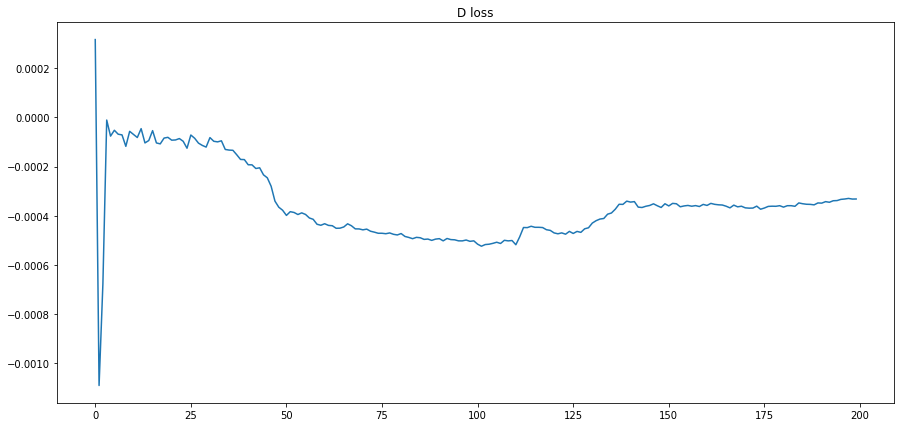

In [17]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.plot(gan.D.logs["train loss"])
plt.show()

In [19]:
batch_synthetic = generate_samples(gan.G, 25, 100)

In [20]:
batch_synthetic

array([[ 3.,  3., 42.,  0.,  2.,  2.,  3.,  4.,  2.],
       [ 5.,  2., 88.,  3.,  5.,  1.,  1.,  3.,  1.],
       [ 8.,  5., 43.,  3.,  0.,  1.,  4.,  2.,  0.],
       [ 4.,  4., 40.,  3.,  0.,  1.,  2.,  1.,  1.],
       [ 7.,  5., 93.,  4.,  7.,  2.,  6.,  4.,  0.],
       [ 5.,  4.,  3.,  0.,  0.,  2.,  4.,  3.,  2.],
       [ 4.,  5., 38.,  2.,  0.,  2.,  4.,  2.,  2.],
       [ 3.,  3., 17.,  3.,  0.,  2.,  2.,  1.,  3.],
       [ 6.,  5., 29.,  0.,  0.,  1.,  3.,  2.,  0.],
       [ 4.,  6., 30.,  0.,  9.,  2.,  4.,  2.,  2.],
       [ 3.,  5., 83.,  3.,  8.,  2.,  6.,  3.,  2.],
       [ 4.,  2., 28.,  3.,  0.,  2.,  3.,  3.,  2.],
       [ 6.,  5., 15.,  2.,  0.,  1.,  2.,  3.,  0.],
       [ 3.,  5., 37.,  1.,  0.,  2.,  4.,  2.,  2.],
       [ 3.,  3., 52.,  0.,  4.,  2.,  3.,  2.,  2.],
       [ 3.,  1., 68.,  1.,  3.,  1.,  0.,  4.,  1.],
       [ 5.,  2., 22.,  0.,  1.,  2.,  2.,  2.,  2.],
       [ 3.,  4.,  2.,  0.,  0.,  2.,  3.,  2.,  2.],
       [ 5.,  5., 72.,  0., 